In [10]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import TreebankWordTokenizer
from nltk.stem import PorterStemmer
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.metrics.pairwise import cosine_similarity
import re
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA




In [11]:
resumes = pd.read_csv('resumes.csv')

In [12]:
resumes


,Resumes,Person
0,eCommerce Analyst / Category Specialist\nCompa...,Ryan Clohessy
1,Experience\nElectronic Arts (EA)\nGlobal Marco...,Russell Escalada
2,Experience\nWalmart eCommerce\nCompany NameWal...,Xiu Li
3,Experience\nAvascent\nCompany NameAvascent\nTo...,Shawdon Zadeh
4,Courtney Schaf\n 1st degree connection1st\nCou...,Courtney Schaf
5,Preston Lam\nPreston has a account\nData Scien...,Preston Lam


In [13]:
import pandas as pd
df = pd.read_csv('jobs.csv')


In [18]:
%%time
def tokenize_stem(series):

    tokenizer =TreebankWordTokenizer()
    stemmer = PorterStemmer()
    series = series.apply(lambda x: tokenizer.tokenize(x))
    series = series.apply(lambda x: [stemmer.stem(w) for w in x])
    series = series.apply(lambda x: ' '.join(x))
    return series

def display_topics(model, feature_names, no_top_words, topic_names=None):
    topic_list = []
    for i, topic in enumerate(model.components_):
#         if not topic_names or not topic_names[i]:
#             print("\nTopic ", i)
#         else:
#             print("\nTopic: '",topic_names[i],"'")
        
#         print(", ".join([feature_names[k]
#                        for k in topic.argsort()[:-no_top_words - 1:-1]]))
        topic_list.append(", ".join([feature_names[k]
                       for k in topic.argsort()[:-no_top_words - 1:-1]]))
    return model.components_, topic_list


def return_topics(series, num_topics, no_top_words, model, vectorizer):
    #turn job into series
    series = tokenize_stem(series)
    #transform series into corpus
    ex_label = [e[:30]+"..." for e in series]
    #set vectorizer ngrams = (2,2)
    vec = vectorizer(stop_words = 'english')

    doc_word = vec.fit_transform(series)

    #build model
    def_model = model(num_topics)
    doc_topic = def_model.fit_transform(doc_word)
    print('model components: ', def_model.components_[0].shape)
    print('doc_topic', doc_topic[0])
    model_components, topic_list = display_topics(def_model, vec.get_feature_names(), no_top_words)
    return def_model.components_, doc_topic, def_model, vec, topic_list#, topics

def process_data():
    #read in jobs file and get descriptions
    df = pd.read_csv('jobs.csv')
    #df = df[df.keyword!='marketing']
    jobs_df = pd.DataFrame(zip(df['Job Description'], df['keyword']), columns = ['Description', 'Job'])

    array, doc, topic_model, vec, topic_list  = return_topics(jobs_df['Description'],20, 10, TruncatedSVD, TfidfVectorizer)
    doc.shape

    topic_df = pd.DataFrame(doc)
    topic_df.columns = ['Topic ' + str(i+1) for i in range(len(topic_df.columns)) ]

    topic_df['job'] = jobs_df.Job
    #Topic_DF.to_csv('topic_df.csv')
    return topic_df, topic_model, vec, topic_list

def predictive_modeling(df):
    '''
    fits, optimizes, and predicts job class based on topic modeling corpus
    '''
    X,y = df.iloc[:,0:-1], df.iloc[:, -1]
    X_tr, X_te, y_tr, y_te = train_test_split(X,y)

    param_grid = {'n_estimators': [100,300, 400, 500, 600], 'max_depth': [3,7,9, 11]}
    # search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
    # search.fit(X_tr, y_tr)
    # bp = search.best_params_
    # print(bp)
    #rfc = RandomForestClassifier(n_estimators = bp['n_estimators'], max_depth = bp['max_depth'])
    rfc = RandomForestClassifier(n_estimators = 500, max_depth = 9)
    rfc.fit(X_tr, y_tr)
    print('acc: ', np.mean(cross_val_score(rfc, X_tr, y_tr, scoring = 'accuracy', cv=5)))
    print('test_acc: ', accuracy_score(y_te, rfc.predict(X_te)))
    print(rfc.predict(X_te))
    return rfc

def predict_resume(topic_model, model, resume):
    '''
    transforms a resume based on the topic modeling model and return prediction probabilities per each job class
    '''
    doc = topic_model.transform(resume)
    return model.predict_proba(doc), model.classes_, doc

def main():
    jobs_df, model, vec, topic_list = process_data()
    model_1 = predictive_modeling(jobs_df)
    
    for i,doc in enumerate(resumes.Resumes):
        doc = tokenize_stem(pd.Series(doc))
        doc = vec.transform(doc)
        #do cosine similarity compared to job 1 to job 100
        #this would spit out the specifc job application + 
        print(resumes.Person[i])
        print('----------------')
        probabilities, classes,doc1 = predict_resume(model, model_1, doc)
#         for i in range(len(probabilities[0])):
#             print(classes[i], ': ', probabilities[0][i]*100, '%')
        print(doc)
    
#     doc1 = resumes.Resumes[0]
#     doc1 = tokenize_stem(pd.Series(doc1))
#     doc1 = vec.transform(doc1)
    
#     probabilities, classes = predict_resume(model, model_1, doc1)
#     return probabilities, classes
main()
# look at topics and see what makes sense

# recommend roles that are best for you based on supervised learnings

# these are the jobs descriptions that are best for you based on your resume

# these are the best words for your resume based on which job you want to go into


# NEXT STEPS:
# Now we have to fit resumes according to the topic modeling model -
    #we my want to add a new function in here to fit the resumes and test out the product

    #then we have to turn the model into a streamlit app

    #last we want to make the app pretty and have users test it / upload it to the internet for real

    #make presentation

# Also have to create app and return the

#get chart of top toppics from topic modeling


model components:  (5261,)
doc_topic [ 0.33272072  0.27646678 -0.07798066 -0.04647066  0.05019964  0.0228899
 -0.00861196  0.02302052  0.06580954  0.09327324 -0.01719657  0.05290303
 -0.09314644  0.01838384 -0.01311836 -0.02213972 -0.0713546   0.01704483
  0.03484324  0.00834481]
acc:  0.8648275862068967
test_acc:  0.88
['ux,designer' 'sales' 'ux,designer' 'product,manager' 'consultant'
 'consultant' 'project,manager' 'sales' 'consultant' 'project,manager'
 'project,manager' 'sales' 'product,manager' 'sales' 'consultant'
 'ux,designer' 'sales' 'project,manager' 'marketing' 'project,manager'
 'product,manager' 'account,manager' 'account,manager' 'ux,designer'
 'data,analyst' 'sales' 'data,analyst' 'consultant' 'project,manager'
 'data,analyst' 'ux,designer' 'sales' 'sales' 'ux,designer' 'ux,designer'
 'ux,designer' 'sales' 'sales' 'sales' 'product,manager' 'sales'
 'ux,designer' 'data,analyst' 'product,manager' 'ux,designer'
 'account,manager' 'sales' 'ux,designer' 'sales' 'product,mana

In [19]:
import matplotlib.pyplot as plt

In [20]:
def create_clusters():
    topic_df, model, vec, topic_list = process_data()
    pca = PCA(n_components=2)
    X_train = topic_df.iloc[:, :-1]
    y_train = topic_df.iloc[:, -1]
    y_vals = y_train.unique()
    pca.fit(X_train)
    return X_train, pca.transform(X_train), y_train, y_vals, topic_list
     
from itertools import cycle

def plot_PCA_2D(data, target, target_names):
    colors = cycle(['r','g','b','c','m','y','orange','w','aqua','yellow'])
    target_ids = range(len(target_names))
    plt.figure(figsize=(10,10))
    for i, c, label in zip(target_ids, colors, target_names):
        plt.scatter(data[target == i, 0], data[target == i, 1],
                   c=c, label=label, edgecolors='gray')
    plt.title('Clustering Job Archetypes')
    plt.xlabel('Marketing / Design Words')
    plt.ylabel('Management / Finance Words')
    plt.legend()

model components:  (5261,)
doc_topic [ 0.33272073  0.27646775 -0.07798326 -0.04655757  0.05088724  0.02130048
 -0.00956873  0.02047981  0.06668087  0.0868336  -0.01633572  0.06916151
 -0.09773062  0.01143392 -0.04371109 -0.00912041  0.03791434  0.03942179
  0.10329888 -0.0152675 ]


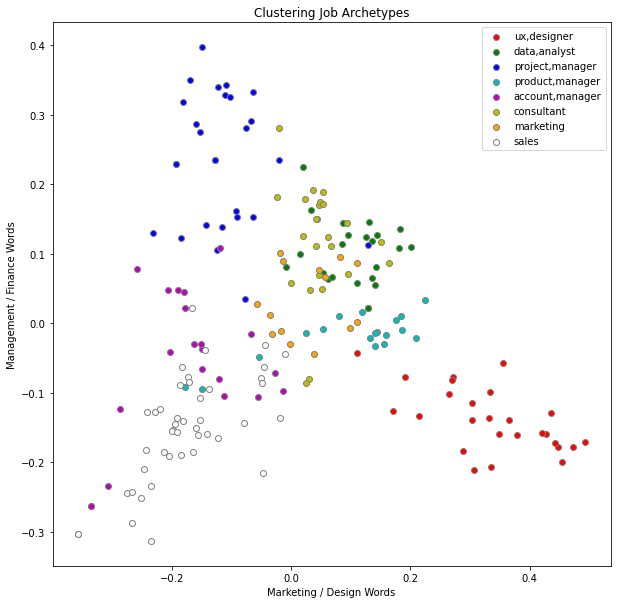

In [17]:
X_train, pca_train, y_train, y_vals, topic_list = create_clusters()

for i, val in enumerate(y_train.unique()):
    y_train = y_train.apply(lambda x: i if x == val else x)


plot_PCA_2D(pca_train, y_train, y_vals)

In [ ]:

def get_topic_words():
    jobs_df, model, vec, topic_list = process_data()
    
    topic_dict = {}
    for i in range(0, len(topic_list)):
        topic_dict[i] = topic_list[i]
    return topic_dict


In [76]:
pca = PCA(n_components = 2)
pca.fit(X_train)
X_transf = pca.transform(X_train)
print("shape of original X_train:", X_train.shape)
print("shape of X_train using 2 principal components:", X_transf.shape, "\n")
print(X_transf)


shape of original X_train: (197, 20)
shape of X_train using 2 principal components: (197, 2) 

[[ 2.72049570e-01 -7.74694622e-02]
 [ 2.64393914e-01 -1.01999092e-01]
 [ 2.13927847e-01 -1.33384290e-01]
 [ 4.26682418e-01 -1.59720315e-01]
 [ 3.07568437e-01 -2.11701230e-01]
 [ 4.47765468e-01 -1.78356814e-01]
 [ 3.78841341e-01 -1.61014898e-01]
 [ 3.03389632e-01 -1.15286291e-01]
 [ 3.32323502e-01 -1.36665303e-01]
 [ 1.90964582e-01 -7.69981753e-02]
 [ 1.11285662e-01 -4.24561296e-02]
 [ 3.32724169e-01 -9.89356526e-02]
 [ 3.48733305e-01 -1.59845786e-01]
 [ 4.21173532e-01 -1.58209628e-01]
 [ 2.70243812e-01 -8.22528527e-02]
 [ 4.92843580e-01 -1.70668083e-01]
 [ 4.73122518e-01 -1.77783562e-01]
 [ 4.42766495e-01 -1.72275234e-01]
 [ 4.34732089e-01 -1.29303592e-01]
 [ 3.03503162e-01 -1.39056160e-01]
 [ 1.70084125e-01 -1.26887677e-01]
 [ 3.34512707e-01 -2.06791859e-01]
 [ 3.65294390e-01 -1.40196004e-01]
 [ 2.89063058e-01 -1.84125850e-01]
 [ 3.54278262e-01 -5.71066730e-02]
 [ 4.54571009e-01 -2.00415794e

In [77]:
pca.explained_variance_ratio_

array([0.14773789, 0.09869852])

In [78]:
pca_df = pd.DataFrame(pca.components_, index = ['PC1','PC2'])

In [79]:
topic_dict = get_topic_words()
pca_df.columns = [topic_dict[i] for i in range(len(pca_df.columns))]
pca_df

model components:  (5261,)
doc_topic [ 0.33272073  0.27647809 -0.07803862 -0.04660335  0.04958446  0.0220365
 -0.00621204  0.0198732   0.07235341  0.09173268 -0.02691808  0.04600655
 -0.10515597  0.02268315 -0.03439136 -0.01213934 -0.03163621  0.05307718
  0.14611923  0.04189632]

Topic  0
sale, manag, work, experi, design, project, custom, market, product, client

Topic  1
design, ux, user, data, ui, visual, experi, product, interact, prototyp

Topic  2
project, construct, manag, consult, data, client, subcontractor, report, budget, owner

Topic  3
market, data, analyt, consult, busi, sale, analyst, campaign, strategi, help

Topic  4
client, consult, strategi, firm, valu, busi, team, peopl, servic, deliv

Topic  5
market, campaign, content, email, brand, media, manag, channel, growth, social

Topic  6
sale, construct, project, custom, roostifi, help, solar, roof, understand, lend

Topic  7
sale, clinic, consult, project, trial, diagnost, molecular, biolog, develop, healthcar

Topic  8

,"sale, manag, work, experi, design, project, custom, market, product, client","design, ux, user, data, ui, visual, experi, product, interact, prototyp","project, construct, manag, consult, data, client, subcontractor, report, budget, owner","market, data, analyt, consult, busi, sale, analyst, campaign, strategi, help","client, consult, strategi, firm, valu, busi, team, peopl, servic, deliv","market, campaign, content, email, brand, media, manag, channel, growth, social","sale, construct, project, custom, roostifi, help, solar, roof, understand, lend","sale, clinic, consult, project, trial, diagnost, molecular, biolog, develop, healthcar","product, roostifi, custom, lend, clinic, manag, account, molecular, trial, technic","diagnost, biolog, molecular, consult, clinic, scientif, healthcar, adivo, product, year","diagnost, biolog, molecular, birdey, estimates, client, bid, scientif, world, construct","assist, estimates, bid, consult, strong, sale, good, negotiable, caroneandcompany, deliveries","adivo, custom, consult, healthcar, construct, market, model, product, employ, segment","dropbox, custom, roof, birdey, product, order, data, file, awt, superintendent","birdey, trial, insur, ms, customers, everi, skills, clinic, increas, attitud","paypal, dropbox, research, roof, assist, employe, file, peopl, enrol, clinic","roostifi, lend, dropbox, solar, project, commiss, new, prototyp, mgr, highli","ms, strong, 00, hghw, enthusiast, doer, experi, 16, rapport, database","slakey, roostifi, brother, technic, experi, lend, deloitt, hvac, plumb, paypal","paypal, financi, adivo, solar, dropbox, account, manag, deloitt, healthcar, product"
PC1,-0.048320,0.998815,-0.000364,-0.000741,-0.001752,-0.003383,0.000801,-0.000509,-0.00257,0.002425,0.001167,0.000588,-0.000767,0.000030,0.000424,0.000756,-0.000027,-0.001218,0.000543,-0.000352
PC2,0.006673,0.000699,0.999975,0.001442,0.000715,0.001203,-0.000257,0.000157,0.00076,-0.000706,-0.000333,-0.000165,0.000214,-0.000008,-0.000116,-0.000206,0.000007,0.000329,-0.000146,0.000094
